In [1]:
#Load all important packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt 
import seaborn as sns

tfd = tfp.distributions

In [2]:
#Load dataset
df = pd.read_csv('../input/winecsv/wine.csv')
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,3
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


Look at the frequencies of each label

[Text(0, 0.5, '%'), Text(0.5, 0, 'Quality of wine')]

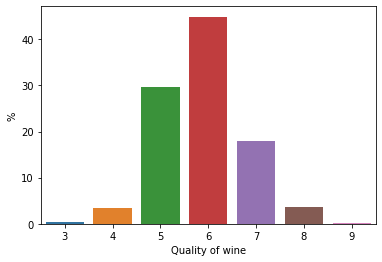

In [3]:
sns.barplot(x="quality",y="quality",data=df,
            estimator=lambda x: len(x) / len(df.type) * 100).set(ylabel="%",xlabel="Quality of wine")

Most wines are given "moderate" qualities: 5, 6 and 7. 
Let us now have a look at the distribution of the features.

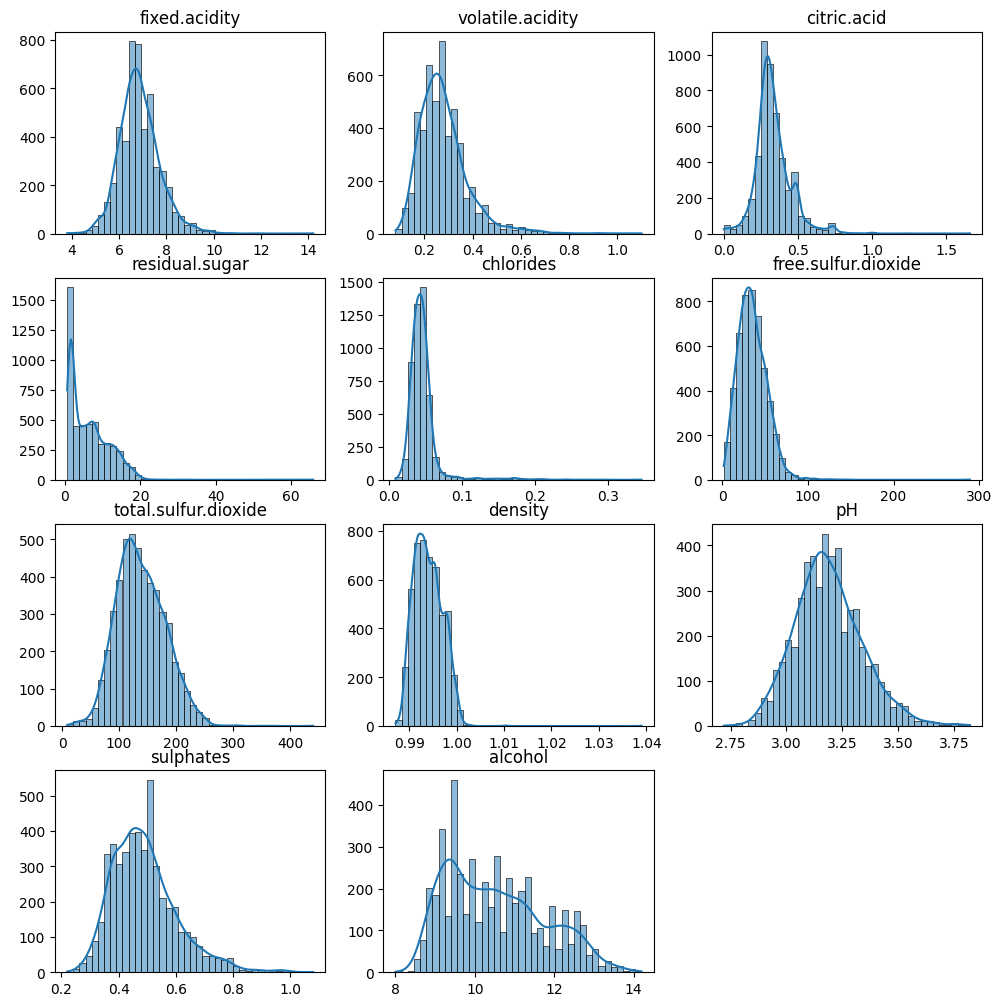

In [4]:
#Further exploration of variables

number_of_variables = df.shape[1] -2
n_subplot_rows = 3
n_subplot_cols = (number_of_variables + 1) // n_subplot_rows
fig, ax = plt.subplots(4, 3, figsize=(10,10), dpi=100)
fig.tight_layout()

features = pd.DataFrame(df.iloc[:-2],columns=df.columns.values[:-2])

for i in range(4):
    for j in range(3):
        idx = 3*i +j
        if idx< number_of_variables:
            sns.histplot(features.iloc[:,idx],ax=ax[i][j],bins=40,kde='True')
            ax[i,j].set(xlabel=None)
            ax[i,j].set(ylabel=None)
            ax[i,j].title.set_text('{}'.format(df.columns.values[idx]))
        else:
            ax[i, j].axis('off')


In [5]:
def scatter_2d_label_with_subset(X_2d, y,subset, ax=None, s=0.5, alpha=0.85, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
        
    subset : ndarray
        subset of points to be flagged on the plot
    """
    
    targets = np.unique(y)# extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
        
    ax.scatter(X_2d[subset, 0],X_2d[subset, 1],color='black')
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

In [6]:
#Convert quality to float
y=df.iloc[:,-2].astype(float).values
X=df.iloc[:,:-2]

#Standarization of features (extremely important for PCA, LDA, SVM,...)
from sklearn.preprocessing import StandardScaler
esc=StandardScaler()
X_esc = esc.fit_transform(X)

Variance explained by the 2 first pca components: 0.44


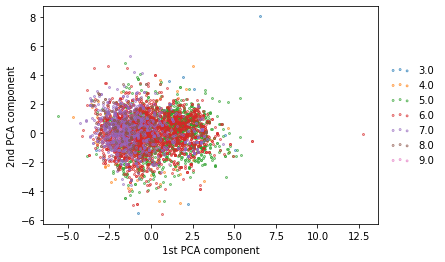

In [7]:
# PCA 2-dimensional representation
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_esc)
print('Variance explained by the '+str(n_components)+' first pca components: '+str(round(np.sum(pca.explained_variance_ratio_),2)))

#Plot first two components on a scatter plot
fig, ax = plt.subplots()
scatter_2d_label_with_subset(X_pca, y, ax=ax,subset=[])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');


We split our data into training and validation in order to validate our baseline (non-Bayesian) models. We will use the whole dataset to train our Bayesian neural network (BNN).

In [8]:
#Hold out a test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-2],df.iloc[:,-2],random_state=2,test_size=0.25)
#Convert quality to float
y_train=y_train.astype(float).values
y_test=y_test.astype(float).values

#Standarization (extremely important for PCA, LDA, SVM,...)
from sklearn.preprocessing import StandardScaler
esc=StandardScaler()
X_train = esc.fit_transform(X_train)
esc=StandardScaler()
X_test = esc.fit_transform(X_test)


In [9]:
def scatter_2d_label(X_2d, y, ax=None, s=0.5, alpha=0.85, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    
    targets = np.unique(y)# extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
    
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

### A couple of baseline models (linear regression and random forest)

MSE on train set: 0.5614521785715895
MSE on test set: 0.5735929659368191

First 10 predictions for the test set:

Predicted: 5.58 - Actual: 5.0
Predicted: 6.2 - Actual: 7.0
Predicted: 5.98 - Actual: 6.0
Predicted: 4.92 - Actual: 5.0
Predicted: 6.65 - Actual: 6.0
Predicted: 6.35 - Actual: 7.0
Predicted: 6.15 - Actual: 6.0
Predicted: 6.3 - Actual: 6.0
Predicted: 5.93 - Actual: 7.0
Predicted: 6.26 - Actual: 6.0


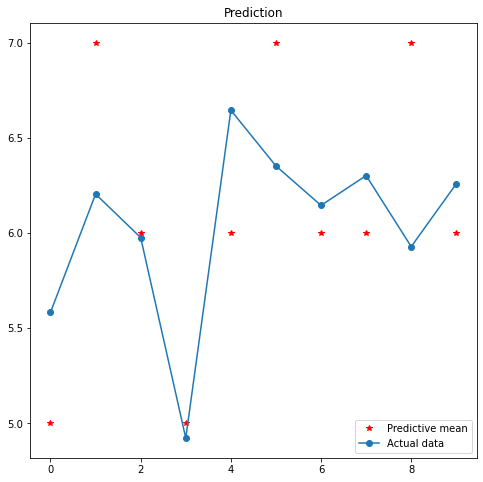

In [10]:
#Linear regression
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)

from sklearn.metrics import mean_squared_error

print('MSE on train set: '+str(mean_squared_error(y_train,lin_reg.predict(X_train))))
print('MSE on test set: '+str(mean_squared_error(y_test,lin_reg.predict(X_test)))+"\n")

def predict_and_plot(n_samples,y_pred,y_true,y_sigma):
    """
    See prediction of the first elements of the testing set
    
    n_samples : int
    Number of samples to predict from the test set
    
    y_pred : ndarray, shape (n_samples,)
    Predicted values
    
    y_true: ndarray, shape (n_samples,)
    Actual values
    
    y_sigma: ndarray, shape(n_samples,)
    Uncertainty of predictions
    
    """
    
    
    print('First '+str(n_samples)+" predictions for the test set:"+"\n")
    if type(y_sigma)!=np.ndarray:
        for idx in range(n_samples):
            print(f"Predicted: {round(float(y_pred[idx]), 2)} - Actual: {y_true[idx]}") 
    else:
        for idx in range(n_samples):
            print(
                f"Prediction mean: {round(float(y_mean[idx]), 2)},  "
                f"stddev: {round(float(y_sigma[idx]), 2)},  "
                f"95% CI: [{round(float(y_pred[idx] + 1.96*y_sigma[idx]), 2)} , {round(float(y_pred[idx] - 1.96*y_sigma[idx]), 2)}] "
                f" - Actual: {y_test[idx]}"
            )

        
    plt.figure(figsize=(8,8))
    plt.plot(list(range(n_samples)),y_true[:n_samples],'r*',label='Predictive mean');
    plt.plot(list(range(n_samples)),y_pred[:n_samples],'-o', label='Actual data')
    if type(y_sigma)==np.ndarray:
        plt.fill_between(list(range(n_samples)),
                     y_pred[:n_samples] + 1.96 * y_sigma[:n_samples],
                     y_pred[:n_samples] - 1.96 * y_sigma[:n_samples],
                 alpha=0.5, label='Aleatoric + epistemic uncertainty, 95% CI',color='g')
    plt.title('Prediction')
    plt.legend()
    plt.show()
        
predict_and_plot(n_samples = 10,
                 y_pred = lin_reg.predict(X_test),
                 y_true = y_test,
                y_sigma = "None")




MSE on train set: 0.05011729049823033
MSE on test set: 0.4087116865306123

First 10 predictions for the test set:

Predicted: 5.14 - Actual: 5.0
Predicted: 5.87 - Actual: 7.0
Predicted: 6.11 - Actual: 6.0
Predicted: 4.99 - Actual: 5.0
Predicted: 6.39 - Actual: 6.0
Predicted: 6.15 - Actual: 7.0
Predicted: 5.88 - Actual: 6.0
Predicted: 6.33 - Actual: 6.0
Predicted: 6.33 - Actual: 7.0
Predicted: 5.68 - Actual: 6.0


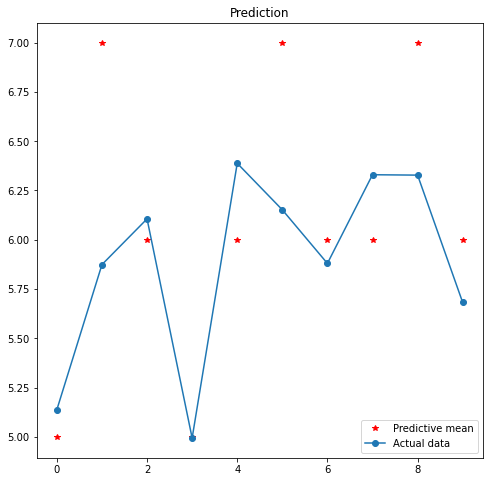

In [11]:
#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(n_estimators=500,max_leaf_nodes=3000)
RFR.fit(X_train,y_train)

print('MSE on train set: '+str(mean_squared_error(y_train,RFR.predict(X_train))))
print('MSE on test set: '+str(mean_squared_error(y_test,RFR.predict(X_test)))+"\n")

predict_and_plot(n_samples = 10,
                 y_pred = RFR.predict(X_test),
                 y_true = y_test,
                y_sigma = "None")


### Vanilla NN

Train a baseline non-Bayesian NN

In [12]:
#Take the whole train set as batch
batch = X_train.shape[0]

vanilla_model = keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        layers.Input(shape=(X_train.shape[1])),
        layers.Dense(12, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Dense(1, activation = 'linear')])

n_epochs=500
vanilla_model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')
vanilla_history=vanilla_model.fit(X_train, y_train,epochs=n_epochs,
                                  verbose=0,validation_data=(X_test,y_test),batch_size=batch)

[Text(0.5, 0, 'Epoch')]

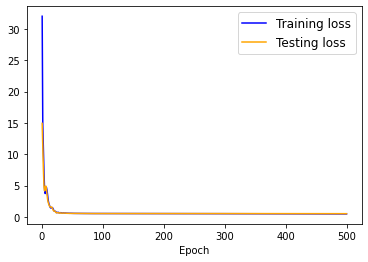

In [13]:
#Visualise loss (mean squared error) on both the training and testing set

ax=sns.lineplot(x=1+np.arange(n_epochs), y=vanilla_history.history['loss'],color='blue')
sns.lineplot(x=1+np.arange(n_epochs), y=vanilla_history.history['val_loss'],color='orange')
ax.legend(['Training loss','Testing loss'],fontsize=12)
ax.set(xlabel='Epoch')

The baseline model does not seem to overfit

MSE on train set: 0.4809498275603951
MSE on test set: 0.5200630353358252

First 10 predictions for the test set:

Predicted: 5.39 - Actual: 5.0
Predicted: 6.2 - Actual: 7.0
Predicted: 5.79 - Actual: 6.0
Predicted: 4.91 - Actual: 5.0
Predicted: 6.29 - Actual: 6.0
Predicted: 6.19 - Actual: 7.0
Predicted: 5.91 - Actual: 6.0
Predicted: 5.92 - Actual: 6.0
Predicted: 5.69 - Actual: 7.0
Predicted: 5.92 - Actual: 6.0


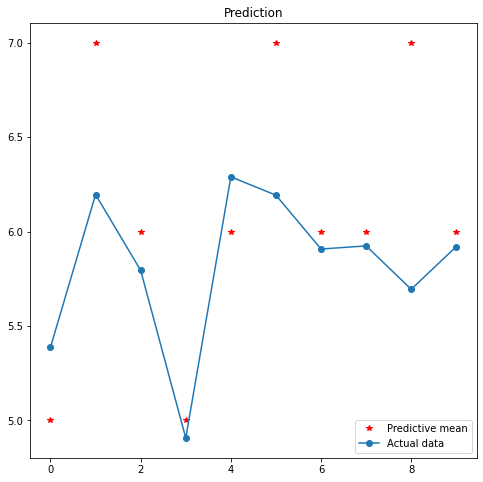

In [14]:
print('MSE on train set: '+str(mean_squared_error(y_train,vanilla_model.predict(X_train))))
print('MSE on test set: '+str(mean_squared_error(y_test,vanilla_model.predict(X_test)))+"\n")

predict_and_plot(n_samples = 10,
                 y_pred = vanilla_model.predict(X_test),
                 y_true = y_test,
                 y_sigma = "None")


Better performance than simple linear regression but worse than random forest. However, we shall focus on NNs.

### Bayesian neural network

Use the whole dataset to train the model

In [15]:
#Convert quality to float
y_train=df.iloc[:,-2].astype(float).values
y_test=y_train
X=df.iloc[:,:-2]

esc = StandardScaler()

X_train = esc.fit_transform(X)
X_test = X_train #No splil!!


In [16]:
# We need to scale our Kullback-Leibler (KL) divergence with the inverse of the batch size
# (see Keras documentation)

batch_size = X_train.shape[0]
def kl_divergence_function(q,p,_):
    return tfd.kl_divergence(q, p) /tf.cast(batch_size, dtype=tf.float32)

'''
We consider a similar architecture as before. There are three hidden DenseFlipout layers
(see https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout) with
the same number of nodes as in the non-Bayesian setting. The output is a normal distribution
whose mean and standard deviation are given by the last hidden layer.

We use an ELBO loss function (defined below)
'''

full_model = tf.keras.Sequential([
  tf.keras.Input(shape=X_train.shape[1]),
     
  tfp.layers.DenseFlipout(
      units=12,
      activation='relu',
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      kernel_divergence_fn=kl_divergence_function),
    
  tfp.layers.DenseFlipout(
      units=6,
      activation='relu',
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      kernel_divergence_fn=kl_divergence_function),
    

  tfp.layers.DenseFlipout(
      units=2,
      activation='linear',
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      kernel_divergence_fn=kl_divergence_function),

  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1],
                            scale=1e-3 + 0.05*tf.math.softplus(t[...,1:])))
])




#Return the negative log likelihood
def neg_log_likelihood(y_true, y_pred_distr):
    return -tf.reduce_mean(y_pred_distr.log_prob(y_true))

# The ELBO loss function is the sum of the KL term (we get it directly from the DenseFlipout layers)
# and the negative log likelihood
def loss(y_true,y_pred_distr,model=full_model):
    nll = neg_log_likelihood(y_true, y_pred_distr)
    kl = tf.keras.losses.kullback_leibler_divergence(y_true, y_pred_distr)
    
    return kl + nll



# Do inference.
n_epochs=300
full_model.compile(optimizer=tf.optimizers.Adam(lr=0.01), loss=loss , metrics=['mse'])

full_history=full_model.fit(X_train, y_train, epochs=n_epochs, verbose=0)



/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


[Text(0.5, 0, 'Epoch')]

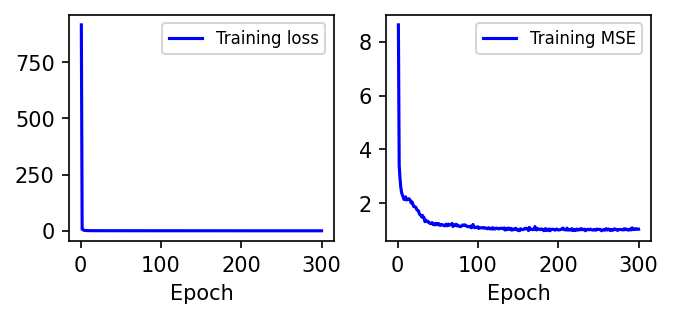

In [17]:
#print(vanilla_history.history.keys())
fig, ax = plt.subplots(1, 2, figsize=(5,2), dpi=150)

#"Loss"
sns.lineplot(x=1+np.arange(n_epochs), y=full_history.history['loss'],ax=ax[0],color='blue')
#sns.lineplot(x=1+np.arange(n_epochs), y=full_history.history['val_loss'],ax=ax[0],color='orange')
ax[0].legend(['Training loss','Testing loss'],fontsize=8)
ax[0].set(xlabel='Epoch')

#"MSE"'
sns.lineplot(x=1+np.arange(n_epochs), y=full_history.history['mse'],ax=ax[1],color='blue')
#sns.lineplot(x=1+np.arange(n_epochs), y=full_history.history['val_mse'],ax=ax[1],color='orange')
ax[1].legend(['Training MSE','Testing MSE'],fontsize=8)
ax[1].set(xlabel='Epoch')


In [18]:
#Take a sample of MC_samples draws from the model to approximate the posterior predictive distribution
import tqdm
from scipy.stats import median_abs_deviation

MC_samples = 1000

y_pred_list = []
for i in tqdm.tqdm(range(MC_samples)):
    y_pred = full_model.predict(X_test)
    y_pred_list.append(y_pred)

#Calculate the mean, standard deviation, median and median absolute deviation
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)
y_median = np.median(y_preds,axis=1)
y_mad = median_abs_deviation(y_preds,axis=1)

# The 95% CI is computed as mean ± (1.96 * stdv)
perc_95 = (y_mean + (1.96 * y_sigma)).tolist()
perc_05 = (y_mean - (1.96 * y_sigma)).tolist()


100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


MSE on test set taking the mean: 0.48805307262576786

MSE on test set taking the median: 0.4881317489576664

First 20 predictions for the test set:

Prediction mean: 5.71,  stddev: 0.65,  95% CI: [6.98 , 4.44]  - Actual: 6.0
Prediction mean: 5.03,  stddev: 0.6,  95% CI: [6.21 , 3.85]  - Actual: 6.0
Prediction mean: 5.85,  stddev: 0.72,  95% CI: [7.26 , 4.44]  - Actual: 6.0
Prediction mean: 5.47,  stddev: 0.6,  95% CI: [6.65 , 4.29]  - Actual: 6.0
Prediction mean: 5.47,  stddev: 0.61,  95% CI: [6.65 , 4.28]  - Actual: 6.0
Prediction mean: 5.83,  stddev: 0.72,  95% CI: [7.24 , 4.41]  - Actual: 6.0
Prediction mean: 5.32,  stddev: 0.51,  95% CI: [6.33 , 4.31]  - Actual: 6.0
Prediction mean: 5.74,  stddev: 0.66,  95% CI: [7.02 , 4.45]  - Actual: 6.0
Prediction mean: 5.05,  stddev: 0.63,  95% CI: [6.28 , 3.82]  - Actual: 6.0
Prediction mean: 5.78,  stddev: 0.7,  95% CI: [7.15 , 4.41]  - Actual: 6.0
Prediction mean: 5.59,  stddev: 0.84,  95% CI: [7.23 , 3.95]  - Actual: 5.0
Prediction mean: 5

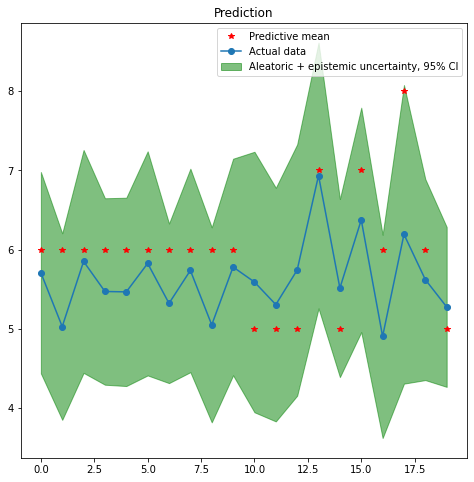

In [19]:
print('MSE on test set taking the mean: '+str(mean_squared_error(y_test,y_mean))+"\n")
print('MSE on test set taking the median: '+str(mean_squared_error(y_test,y_median))+"\n")

predict_and_plot(n_samples = 20,
                 y_pred = y_mean,
                 y_true = y_test,
                 y_sigma = y_sigma
                )


Taking the mean (or the median) of the posterior predictive distribution increases the performance with respect to the non-Bayesian model

### Flag anomalies as test points with a large uncertainty (from a chosen threshold)

Text(0.5, 0, 'log(standard deviation)')

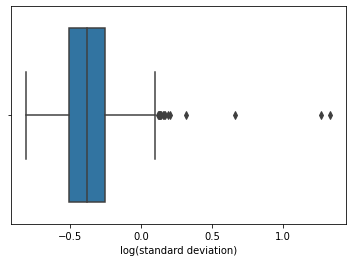

In [20]:
g=sns.boxplot(x=np.log(y_sigma),whis=1.5)
g.set_xlabel('log(standard deviation)')

We may clearly spot the two otliers - both have extreme large uncertainty

Text(0.5, 0, 'log(standard deviation)')

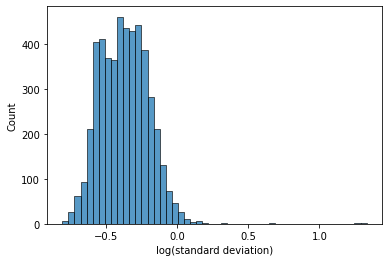

In [21]:
g=sns.histplot(np.log(y_sigma),bins=50)
#g.set_yscale("log")
g.set_xlabel('log(standard deviation)')

[0.29293217 0.14320363 0.11106103]


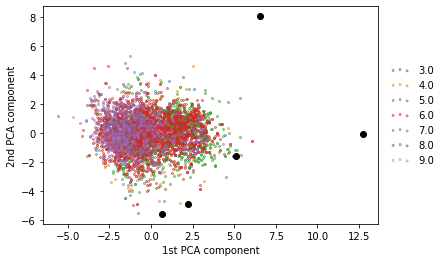

In [22]:
# PCA : Assesss variables' relevance
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)
print(pca.explained_variance_ratio_)
#pca.components_

y=y_test.reshape(-1)
fig, ax = plt.subplots()
#Flag 5 points with largest uncertainty
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=np.argsort(-y_sigma)[:5])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');



In [23]:
#These are the indexes with largest uncertainty
np.argsort(-y_sigma)[:10]

array([2781, 4745, 1526, 2050, 2378, 1951, 4039, 1931, 3773, 3710])

Let us see the features of one of the outliers: the 4745th observation

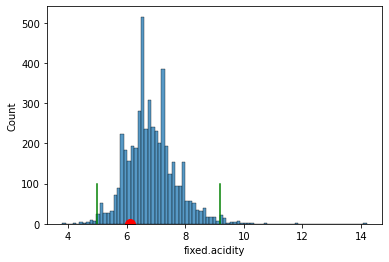

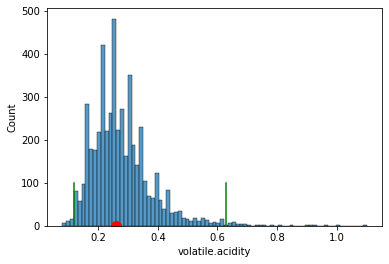

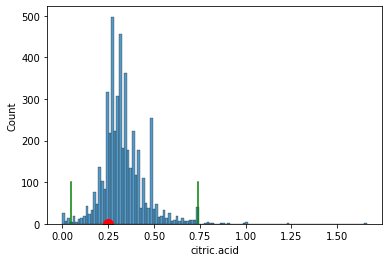

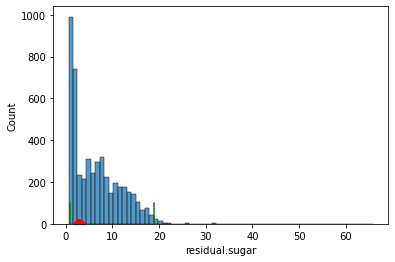

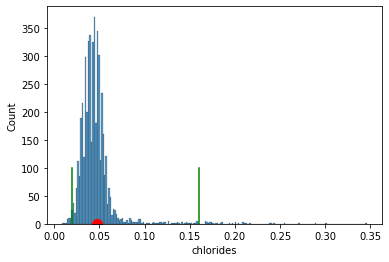

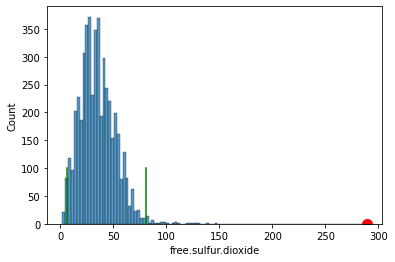

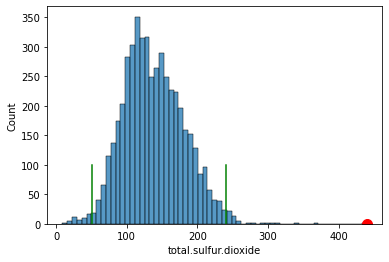

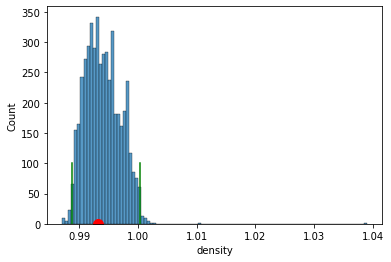

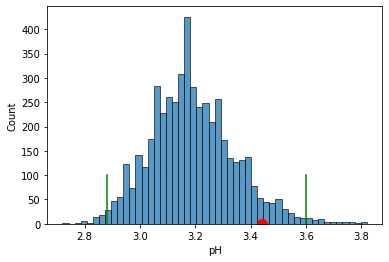

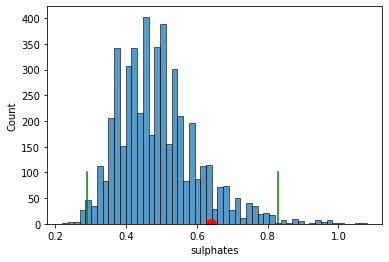

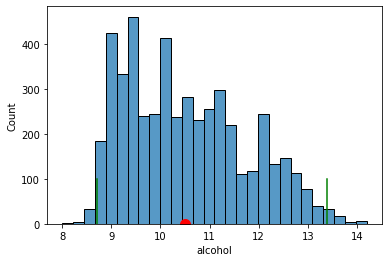

In [24]:
#Plot the 99% confidence interval as well
observation = 4745

for i in range(df.shape[1]-2):
    sns.histplot(pd.DataFrame(esc.inverse_transform(X_test),columns=df.columns.values[:-2]).iloc[:,i])
    plt.plot([np.quantile(esc.inverse_transform(X_test)[:,i],0.99),
              np.quantile(esc.inverse_transform(X_test)[:,i],0.99)],[0,100],'g')
    plt.plot([np.quantile(esc.inverse_transform(X_test)[:,i],0.01),
          np.quantile(esc.inverse_transform(X_test)[:,i],0.01)],[0,100],'g')
    plt.plot(esc.inverse_transform(X_test)[observation,i],[0]*1,'r.',markersize=20)
    plt.show()

We see that one of the outliers has extreme values of free and total sulfur dioxide. The other one is amonalous with respect to the variables residual sugar, volatile acidity and density.

### Compare with Local Outlier Factor (LOF)

In [25]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=60)
clf.fit(X_test)

LocalOutlierFactor(n_neighbors=60)

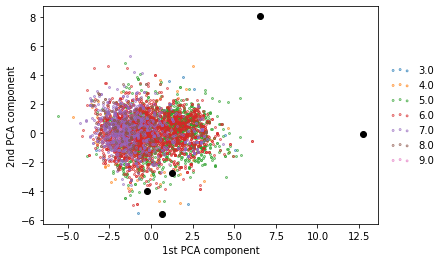

In [26]:
# PCA
fig, ax = plt.subplots()
anomalies_loc = np.argsort(clf.negative_outlier_factor_)
scatter_2d_label_with_subset(X_test_pca, y_test, ax=ax,subset=anomalies_loc[:5])
ax.set(xlabel='1st PCA component', ylabel= '2nd PCA component');



We see that LOF predicts the same two outliers as our model

Let us see the degree of coincidence between LOF and the Bayesian model

In [27]:
lof_pred = clf.fit_predict(X_test)

print('Taking the 10 samples with highest std, LOF flags as outliers:')
print(len([index for index  in np.argsort(-y_sigma)[:10] if lof_pred[index]==-1])/10)

print('Taking the 20 samples with highest std, LOF flags as outliers:')
len([index for index  in np.argsort(-y_sigma)[:20] if lof_pred[index]==-1])/20

Taking the 10 samples with highest std, LOF flags as outliers:
1.0
Taking the 20 samples with highest std, LOF flags as outliers:


0.6

Text(0, 0.5, 'Coincidence')

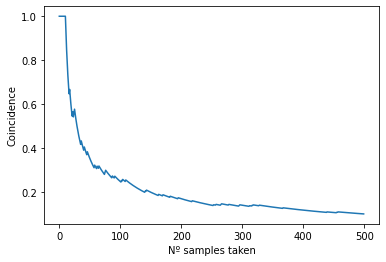

In [28]:
#See it on a plot
grid = list(range(500))
coinc = []
for i in range(1,len(grid)+1):
    coinc.append(len([index for index  in np.argsort(-y_sigma)[:i] if lof_pred[index]==-1])/i)
    
plt.plot(grid,coinc)
plt.xlabel('Nº samples taken')
plt.ylabel('Coincidence')

The ratio of coincidence goes downs as we take samples with lower uncertainty (that neither our  model nor LOF labels as outliers). However, up to 20 samples we have a high coincidence (70%)